***QuantQuote Free Historical Stock Data***

This collection of daily resolution data goes back to 1998 for all symbols currently active in the S&P500. It is updated quarterly, the last update was 07/31/2013 (for more frequent updates, contact us). While this data is available for free from multiple online sources, the QuantQuote Free Daily Data has several advantages not found elsewhere:

***Full split/dividend adjustments for OHLCV***

Single zip file makes downloading ~500 symbols a one step process

QuantQuote data quality means errors in many free sources (such as Yahoo) are not present.

For format information, please consult our minute resolution data documentation.

Our active S&P500 daily resolution collection is provided completely free of charge and because of that, it is not covered under our lifetime support gauranty. Data is provided as is, with no warranty. However, if you do have questions about the data or find errors, please feel free to reach out to our support team at support@quantquote.com.

Happy trading,

The QuantQuote Team

***Splits***

When a stock split occurs, the data is adjusted to reflect this so that the data is more or less continuous. If the stock price is 20 and then a 2:1 split occurs, bringing the price to 10, all data ***before the split date*** is divided by 2. The split factor data column is then multiplied by 2. The data thus reflects how much money an investor would expect to make by investing at the beginning of a period and selling at the end of the period without having to take split discontinuities into account. The true price of the stock on any day can be recovered by multiplying the listed price by the split factor. The open, high, low, close, volume, and dividend columns are all split-adjusted.   ***[In other words, the price shown is the price as if all splits had already occurred]***

In [313]:
import os
import pandas as pd
import requests
import re
import itertools
import time
import pickle
import numpy as np
#from IPython.core.display import HTML
from bs4 import BeautifulSoup
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt

import datetime
import dateutil.parser
import random

def norm_series_by_end_cap(s, market_cap):
    return s * market_cap / s.iloc[-1]

class StockData:

    def __init__(self):
        self.stocks = dict()
        self.sectors = dict()
        self.industries = dict()
        self.market_caps = dict()
        self.market_caps_rel = dict()
        self.names = dict()
        self.sectoravg = dict()
        self.sectorgroup = dict()
        self.hits = dict()
        self.growth_ratio = dict()

    # Setting end_stock = None will use all stocks in the S&P 500
    def create(self, base="/Users/joshuavonkorff/K2/2 - Exploring Data/9 - Project 2",\
                 pathpart = "/quantquote_daily_sp500_83986/daily",\
                 single_stock = None,\
                 begin_stock = 0,\
                 end_stock = 1,\
                 use_NYT = True):
        '''Create StockData object:
        (1) Read all stock names from Quant Quote file.
        [In 2-5, the number of stocks is limited to begin_stock through end_stock - 1]
        (2) Read sector and industry information from Fidelity website
        (3) Read market cap 2018 from Fidelity website
        (4) Read number of NYT hits for each stock
        (5) Calculate growth ratio for each stock
        (6) Calculate average stock data by sector
        (7) Calculate market caps relative to average'''
        os.chdir(base)
        path = base + pathpart
        os.chdir(path)
        
        quantquote_filelist = os.listdir(path=path)
        
        # (1)
        for filename in quantquote_filelist:
            if filename[-7:] == ".pickle":
                continue
            stock_code = filename.split(".")[0].split("_")[1]
            self.stocks[stock_code] = pd.read_csv(filename, header=None, parse_dates=[0])
            self.stocks[stock_code].columns = ['DATE', 'TIME', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME']
            
        # (2) & (3)
        if single_stock:
            stocklist = [single_stock]
        else:
            stocklist = itertools.islice(self.stocks.keys(), begin_stock, end_stock)
        stocknum = 0
        for stock in stocklist:
            stockupper = stock.upper()
            fidelitypage = "https://eresearch.fidelity.com/eresearch/evaluate/snapshot.jhtml?symbols=" + stockupper
            print("Reading stock: " + stockupper + ", which is number: " + str(stocknum))
            stocknum += 1
            page = requests.get(fidelitypage)
            soup = BeautifulSoup(page.content, 'html.parser')
            time.sleep(2)
            lst = list()
            # (2)
            for x in soup(text=re.compile(r"\(GICS")):
                lst.append(x.parent.next_sibling.contents[0].contents[0])
            try:
                sector, industry = lst
                # print(f"Stock {stockupper} has sector '{sector}' and industry '{industry}.'")
                self.sectors[stock] = str(sector)
                self.industries[stock] = str(industry)
            except ValueError:
                print(f"Cannot find stock {stockupper} on Fidelity website.")
            # (3)
            for x in soup(text=re.compile(r"Market Capitalization")):
                market_cap = x.parent.next_sibling.contents[0]
                try:
                    market_cap = market_cap.strip('$')
                    if market_cap[-1] == 'B':
                        market_cap = float(market_cap.strip().strip('B')) * 1000000000
                    elif market_cap[-1] == 'M':
                        market_cap = float(market_cap.strip().strip('M')) * 1000000
                    elif market_cap[-1] == 'K':
                        market_cap = float(market_cap.strip().strip('K')) * 1000
                    else:
                        market_cap = int(market_cap)
                    # print("Market cap is: ", market_cap)
                    self.market_caps[stock] = float(market_cap)
                except:
                    print(f"Cannot get market capitalization for stock {stockupper} on Fidelity website.")
                try:
                    self.names[stock] = str(soup.find(id="companyName").contents[0])
                    # print(f"Name of company: {names[stock]}")
                except:
                    print(f"Cannot get name for stock {stockupper} on Fidelity website.")
            # (4)
            if use_NYT:
                self.hits[stock] = self.get_hits(stock)
                hitdict[stock] = self.hits[stock]
            else:
                try:
                    self.hits[stock] = hitdict[stock]
                except:
                    self.hits[stock] = None
            # (5)
            self.growth_ratio[stock] = self.stocks[stock]['CLOSE'].iloc[-1] / self.stocks[stock]['CLOSE'].iloc[0]
            
        # (6)
        
        # stocks must be sorted or groupby won't work
        sortedstocks = sorted(self.sectors.keys(), key = lambda x: self.sectors[x])

        for sector, group in itertools.groupby(sortedstocks, lambda x: self.sectors[x]):
            grouplist = list(group)
            self.sectorgroup[sector] = grouplist
            sectordf = pd.concat(list(norm_series_by_end_cap(self.stocks[stock][['DATE', 'CLOSE']].set_index('DATE'),\
                                                             self.market_caps[stock])\
                                      for stock in grouplist), axis=1)
            self.sectoravg[sector] = sectordf.mean(axis=1)
            
        # (7)
        
        if single_stock:
            stocklist = [single_stock]
        else:
            stocklist = itertools.islice(self.stocks.keys(), begin_stock, end_stock)
        for stock in stocklist:
            lst = self.market_caps.values()
            try:
                self.market_caps_rel[stock] = self.market_caps[stock] / (sum(lst) / len(lst))
            except:
                pass
            
    def get_market_cap(self, stock, datestring):
        '''
        Find the market cap of the stock at the given date string.
        If the stock closing price is not known at the given date,
        try 10 days forward and 10 days back from that date.'''
        try:
            market_cap2018 = self.market_caps[stock]
        except KeyError:
            return None
        daydelta = datetime.timedelta(days=1)
        date = dateutil.parser.parse(datestring)
        s = self.stocks[stock][['DATE', 'CLOSE']].set_index('DATE')
        for n in range(10):
            try:
                cap = s.loc[date]['CLOSE'] * market_cap2018 / s.iloc[-1]['CLOSE']
                return cap
            except:
                date += daydelta
        date -= daydelta * 10
        for n in range(10):
            try:
                cap = s.loc[date]['CLOSE'] * market_cap2018 / s.iloc[-1]['CLOSE']
                return cap
            except:
                date -= daydelta
        return None

    def get_average_market_cap(self, datestring):
        '''
        Find the average market cap over all stocks whose market cap is known at (or around) the given date.
        Returns a list of: (0) the average, (1) the total, (2) the number of known market caps at this date.
        If no caps are known at (or around) this date, return zero.
        '''
        total_cap = 0
        num_caps = 0
        for stock in self.stocks.keys():
            cap = self.get_market_cap(stock, datestring)
            if cap:
                total_cap += cap
                num_caps += 1
        if total_cap > 0:
            return [total_cap / num_caps, total_cap, num_caps]
        else:
            return None

    def get_cap_ratio(self, stock, datestring = None):
        if not datestring:
            try:
                return self.market_caps[stock]\
                      / self.get_average_market_cap('20130701')[0]
            except:
                return None
        else:
            print(f"In datestring in get_cap_ratio for stock {stock}")
            try:
                return self.get_market_cap(stock, datestring)\
                      / self.get_average_market_cap(datestring)[0]
            except:
                return None
        
    def get_hits(self, stock):
        try:
            dates, hits = get_dates_and_hits(api, q='"' + self.names[stock] + '"', fl="web_url,pub_date", nmax = 10, \
                                  begin_date=self.stocks[stock].set_index('DATE').index[0].strftime("%Y%m%d"), \
                                  end_date=self.stocks[stock].set_index('DATE').index[-1].strftime("%Y%m%d"))
        except (KeyError, IndexError):
            print(f"Can't get NYT hits for stock {stock}")
            hits = None
        return hits
        
    def plot_stock(self, stock, rel = False):
        s = norm_series_by_end_cap(self.stocks[stock][['DATE', 'CLOSE']].set_index('DATE')['CLOSE'], self.market_caps[stock])
        if rel:
            s /= self.get_average_market_cap('20130701')[0]

        plt.figure()
        s.plot()
        plt.gca().set_title(stock)
                    
    def plot_sector(self, sector, rel = False):
        s = self.sectoravg[sector].copy()
        if rel:
            s /= self.get_average_market_cap('20130701')[0]
        
        plt.figure()
        ax = s.plot(y='CLOSE')
        ax.set_title(sector + ": " + str(self.sectorgroup[sector]))

    def plot_growth(self, stock):
        plt.figure()
        stocks[stock].plot(x='DATE', y='CLOSE')
        print(f"From 1998 to 2013, '{stock}' grew by {growth_ratio(stock)}")
        plt.gca().set_title(stock)

    def plot_caps_vs_hits(self, rel = False, sector = None, xmin = None, xmax = None, ymin = None, ymax = None):
        if rel:
            capdict = self.market_caps_rel
        else:
            capdict = self.market_caps
        if sector:
            common_keys = [k for k in capdict.keys() if k in self.hits.keys() and self.hits[k] is not None and k in self.sectors.keys() and self.sectors[k] == sector]
        else:
            common_keys = [k for k in capdict.keys() if k in self.hits.keys() and self.hits[k] is not None]
        x = np.array([capdict[k] for k in common_keys])
        y = np.array([self.hits[k] for k in common_keys])

        plt.plot(x, y, 'bo')
        b, m = polyfit(x, y, 1)
        plt.plot(x, b + x * m, '-')
        plt.xlabel('Final market cap')
        plt.ylabel('Number of mentions in NYT')
        if xmax:
            plt.xlim(xmin = xmin, xmax = xmax)
        if ymax:
            plt.ylim(ymin = ymin, ymax = ymax)
        
    def plot_growth_vs_hits(self, sector = None):
        if sector:
            common_keys = [k for k in self.growth_ratio.keys() if k in self.hits.keys() and self.hits[k] is not None and k in self.sectors.keys() and self.sectors[k] == sector]
        else:
            common_keys = [k for k in self.growth_ratio.keys() if k in self.hits.keys() and self.hits[k] is not None]
        x = np.array([self.growth_ratio[k] for k in common_keys])
        y = np.array([self.hits[k] for k in common_keys])

        plt.plot(x, y, 'bo')
        b, m = polyfit(x, y, 1)
        plt.plot(x, b + x * m, '-')
        plt.xlabel('Growth (market cap ratio), 1998-2013')
        plt.ylabel('Number of mentions in NYT')        

    def plot_caps_vs_growth(self, rel = False, sector = None):
        if rel:
            capdict = self.market_caps_rel
        else:
            capdict = self.market_caps
        if sector:
            common_keys = [k for k in capdict.keys() if k in self.growth_ratio.keys() and self.growth_ratio[k] is not None and k in self.sectors.keys() and self.sectors[k] == sector]
        else:
            common_keys = [k for k in capdict.keys() if k in self.growth_ratio.keys() and self.growth_ratio[k] is not None]
        x = np.array([capdict[k] for k in common_keys])
        y = np.array([self.growth_ratio[k] for k in common_keys])

        plt.plot(x, y, 'bo')
        b, m = polyfit(x, y, 1)
        plt.plot(x, b + x * m, '-')
        plt.xlabel('Final market cap')
        plt.ylabel('Growth (market cap ratio), 1998-2013')        

    def print_table(self, sector = None, sortby = 0):
        '''
        sortby = 0: sort by symbol
        sortby = 1: sort by market cap
        sortby = 2: sort by relative market cap
        sortby = 3: sort by growth ratio
        sortby = 4: sort by hits'''
        print("Stock, market cap, relative market cap, growth ratio, hits")
        if sector:
            lst = [k for k in self.stocks.keys() if k in self.sectors.keys() and self.sectors[k] == sector]
        else:
            lst = self.stocks.keys()
        rows = list()
        for k in lst:
            row = list()
            include = False
            try:
                row.append(k + ": " + str(self.names[k]) + ": ")
            except:
                row.append(k + ": ")
            try:
                row.append(str(self.market_caps[k]) + ", ")
                include = True
            except:
                row.append("no cap, ")
            try:
                row.append(str(self.market_caps_rel[k]) + ", ")
                include = True
            except:
                row.append("no rel cap, ")
            try:
                row.append(str(self.growth_ratio[k]) + ", ")
                include = True
            except:
                row.append("no growth ratio, ")
            try:
                row.append(str(self.hits[k]))
                include = True
            except:
                row.append("no hits")
            if include:
                rows.append(row)
        rows.sort(key = lambda x: x[sortby])
        for row in rows:
            print(row[0] + row[1] + row[2] + row[3] + row[4])
        
    def pickle(self, filename = None):
        if not filename:
            filename = "data"
        with open(filename + ".pickle", 'wb') as f:
            pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)
    
    def picklehits(self, filename = None):
        if not filename:
            filename = "hits"
        with open(filename + ".pickle", 'wb') as f:
            pickle.dump(hitdict, f, pickle.HIGHEST_PROTOCOL)
            
    def __str__(self):
        return f"Num stocks = {len(self.stocks.keys())}, Num sectors = {len(self.sectors.keys())}, " +\
               f"Num industries = {len(self.industries.keys())}, Num market_caps = {len(self.market_caps.keys())}, " +\
               f"Num names = {len(self.names.keys())}, Num sectoravgs = {len(self.sectoravg.keys())}, " +\
               f"Num sectorgroup = {len(self.sectorgroup.keys())}, Num hits = {len(self.hits.keys())}, " +\
               f"Num growth_ratio = {len(self.growth_ratio.keys())}"   

def unpickle_StockData(filename = None):
    if not filename:
        filename = 'data'
    with open(filename + ".pickle", 'rb') as f:
        return pickle.load(f)
    
def unpickle_hitdict(filename = None):
    if not filename:
        filename = 'hits'
    with open(filename + ".pickle", 'rb') as f:
        return pickle.load(f)
        
def list_sectors(self):
    print(list(set(sectors.values())))

In [261]:
# There was a bug in the New York Times Python code so I obtained the code from GitHub and fixed it. 
# It is a short piece of code.  The problem was that some unicode strings were being printed prefixed with a "b"
# which was inserted into the URL of the GET request, making the terms unrecognizable.  I had to decode
# the unicode back into ASCII.

import requests

API_ROOT = 'http://api.nytimes.com/svc/search/v2/articlesearch.'

API_SIGNUP_PAGE = 'http://developer.nytimes.com/docs/reference/keys'

class NoAPIKeyException(Exception):
    def __init__(self, value):
        self.value = value
    def __str__(self):
        return repr(self.value)

class articleAPI(object):
    def __init__(self, key = None):
        """
        Initializes the articleAPI class with a developer key. Raises an exception if a key is not given.
        
        Request a key at http://developer.nytimes.com/docs/reference/keys
        
        :param key: New York Times Developer Key
        
        """
        self.key = key
        self.response_format = 'json'
        
        if self.key is None:
            raise NoAPIKeyException('Warning: Missing API Key. Please visit ' + API_SIGNUP_PAGE + ' to register for a key.')
    
    def _utf8_encode(self, d):
        """
        Ensures all values are encoded in UTF-8 and converts them to lowercase
        
        """
        for k, v in d.items():
            if isinstance(v, str):
                d[k] = v.encode('utf8').lower()
                d[k] = d[k].decode("utf-8") # I am not sure why it utf-8 encoded this
                                            # But I had to undo it or there would be a "b" in front of the string
            if isinstance(v, list):
                for index,item in enumerate(v):
                    item = item.encode('utf8').lower()
                    item = item.decode("utf-8")
                    v[index] = item
            if isinstance(v, dict):
                d[k] = self._utf8_encode(v)
        return d
    
    def _bool_encode(self, d):
        """
        Converts bool values to lowercase strings
        
        """
        for k, v in d.items():
            if isinstance(v, bool):
                d[k] = str(v).lower()
        
        return d

    def _options(self, **kwargs):
        """
        Formats search parameters/values for use with API
        
        :param \*\*kwargs: search parameters/values
        
        """
        def _format_fq(d):
            for k,v in d.items():
                if isinstance(v, list):
                    d[k] = ' '.join(map(lambda x: '"' + x + '"', v))
                else:
                    d[k] = '"' + v + '"'
            values = []
            for k,v in d.items():
                value = '%s:(%s)' % (k,v)
                values.append(value)
            values = ' AND '.join(values)
            return values

        kwargs = self._utf8_encode(kwargs)
        kwargs = self._bool_encode(kwargs)
        values = ''
        
        for k, v in kwargs.items():
            if k is 'fq' and isinstance(v, dict):
                v = _format_fq(v)
            elif isinstance(v, list):
                v = ','.join(v)
            values += '%s=%s&' % (k, v)

        return values

    def search(self, 
                response_format = None, 
                key = None, 
                **kwargs):
        """
        Calls the API and returns a dictionary of the search results
        
        :param response_format: the format that the API uses for its response, 
                                includes JSON (.json) and JSONP (.jsonp). 
                                Defaults to '.json'.
                                
        :param key: a developer key. Defaults to key given when the articleAPI class was initialized.
        
        """
        if response_format is None:
            response_format = self.response_format
        if key is None:
            key = self.key
        
        url = '%s%s?%sapi-key=%s' % (
            API_ROOT, response_format, self._options(**kwargs), key
        )
        
        r = requests.get(url)
        return r.json()

In [233]:
# Notes on NYT API queries:

# NYTimes API specs: https://github.com/NYTimes/public_api_specs
# Python wrapper for API: https://pypi.org/project/nytimesarticle/0.1.0/
# wrapper code: https://github.com/MattDMo/NYTimesArticleAPI/blob/master/NYTimesArticleAPI/search_api.py
# Try it out online: https://developer.nytimes.com/article_search_v2.json#/Console/GET/articlesearch.json
# My key: 45c1113ac6434ecba03ac3c68cc1d71e

# Note: each keyword argument must be passed as a single string, contrary to what the Python API pages say.
# Use Lucene Query Syntax: http://www.lucenetutorial.com/lucene-query-syntax.html

# When you search, the search term "q" will be searched throughout the body of the articles.  That means you can't
# always tell by reading the response where the search term occurred (because you don't get to see the article)
# The lead_paragraph keyword appears to have been disabled, or else I just haven't found which articles it works with.
# Maybe old articles?

#from nytimesarticle import articleAPI

import requests
import IPython.display
import sqlite3
import time
#from IPython.core.display import HTML
from bs4 import BeautifulSoup

class NYTsearch:    
    def __init__(self, api, maxart = 1, get_html = False, verbose = False, sleeptime = 0, **kwargs):
        self.keywords = kwargs
        if sleeptime > 0:
                time.sleep(sleeptime)
        self.articles = api.search(**self.keywords)
        #print(self.articles)
            
        self.web_url = []
        self.snippet = []
        self.author = []
        self.headline = []
        self.news_desk = []
        self.pub_date = []
        self.titlehtml = []
        self.bodyhtml = []
        self.message = "No message"
        self.hits = 0

        try:
            if self.articles['message'] == "API rate limit exceeded":
                self.numart = 0
                self.message = "API rate limit exceeded"
                return
        except:
            pass
        
        self.numart = min([maxart, len(self.articles['response']['docs'])])
    
        try:
            self.hits = self.articles['response']['meta']['hits']
        except:
            self.hits = None
    
        for n in range(0, self.numart):
            try:
                art = self.articles['response']['docs'][n]
                if verbose:
                    print(art)
            except KeyError:
                break
            try:
                self.web_url.append(art['web_url'])
            except KeyError:
                self.web_url.append("")
            try:
                self.snippet.append(art['snippet'])
            except KeyError:
                self.snippet.append("")
            try:
                self.author.append(art['byline']['person'][0]['firstname'] + " " + art['byline']['person'][0]['lastname'])
            except (KeyError, IndexError):
                self.author.append("")
            try:
                self.headline.append(art['headline']['main'])
            except KeyError:
                self.headline.append("")
            try:
                self.news_desk.append(art['new_desk']) # typo in NYT api, it really says new_desk
            except KeyError:
                self.news_desk.append("")
            try:
                self.pub_date.append(art['pub_date'])
            except KeyError:
                self.pub_date.append("")
            titlehtmllst = 0
            bodyhtmllst = 0
            if get_html:
                try:
                    page = requests.get(self.web_url[n])
                    soup = BeautifulSoup(page.content, 'html.parser')
                    #print(soup.prettify())
                    titlehtmllst = soup.find_all('h1')
                    bodyhtmllst = soup.find_all('article')
                    #bodyhtmllst = soup.find_all('p', class_='css-1cy1v93 e2kc3sl0')
                except IndexError:
                    pass
            if titlehtmllst == 0:
                self.titlehtml.append("")
            else:
                self.titlehtml.append(''.join(list(map(str, titlehtmllst))))
            if bodyhtmllst == 0:
                self.bodyhtml.append("")
            else:
                self.bodyhtml.append(''.join(list(map(str, bodyhtmllst))))
            
    def __str__(self):
        result = ""
        for n in range(0, self.numart):
            result += "For article " + str(n) + ":\n"
            try:
                result += "web_url: " + self.web_url[n] + "\n"
            except IndexError:
                pass
            try:
                result += "snippet: " + self.snippet[n] + "\n"
            except IndexError:
                pass
            try:
                result += "author: " + self.author[n] + "\n"
            except IndexError:
                pass
            try:
                result += "headline: " + self.headline[n] + "\n"
            except IndexError:
                pass
            try:
                result += "news desk: " + self.news_desk[n] + '\n'
            except IndexError:
                pass
            try:
                result += "pub date: " + self.pub_date[n] + '\n'
            except IndexError:
                pass
        return result
        
    def display(self, n):
        try:
            IPython.display.display_html(self.titlehtml[n] + self.bodyhtml[n], raw=True)
        except IndexError:
            print("No results found.")

api = articleAPI('45c1113ac6434ecba03ac3c68cc1d71e')

def get_dates_and_hits(api, q, fl, begin_date=None, end_date=None, nmax=10):
    page = 0
    dates = []
    while 1:
        print(f"At page: {page}0-{page}9")
        search_result = NYTsearch(api, maxart=10, q=q, fl=fl, begin_date=begin_date, end_date=end_date, page=page, sleeptime=2)
        page += 1
        #print("Result is: ", search_result)
        if (search_result.numart == 0):
            print("Result has no articles")
            print(search_result.message)
            break
        else:
            for d in search_result.pub_date:
                #print(d.split("T")[0])
                dates.append(d.split("T")[0])
        if page * 10 >= nmax:
            break
    return [dates, search_result.hits]

In [138]:
sd = unpickle_StockData('tenstocks')

EOFError: Ran out of input

In [244]:
sd = StockData(single_stock = 'mwv')

Reading stock: MWV, which is number: 0
Cannot find stock MWV on Fidelity website.
Can't get NYT hits for stock mwv


In [282]:
sd.pickle('test')

PicklingError: Can't pickle <class '__main__.StockData'>: it's not the same object as __main__.StockData

In [197]:
lst = itertools.islice(range(20), 0, 3)
for elt in lst:
    print(elt)

0
1
2


In [298]:
sd = StockData()

In [301]:
sd.hits

{'ca': 53,
 'cat': 186,
 'coh': None,
 'dlph': 0,
 'life': 0,
 'lsi': 0,
 'mcd': 18,
 'mwv': None,
 'pnr': 15,
 'twc': None}

In [302]:
sd.create(begin_stock = 10, end_stock = None, use_NYT = False)

Reading stock: GLW, which is number: 0
Reading stock: BDX, which is number: 1
Reading stock: KMI, which is number: 2
Reading stock: ECL, which is number: 3
Reading stock: RAI, which is number: 4
Cannot find stock RAI on Fidelity website.
Reading stock: GME, which is number: 5
Reading stock: ETR, which is number: 6
Reading stock: PLL, which is number: 7
Cannot find stock PLL on Fidelity website.
Reading stock: LO, which is number: 8
Cannot find stock LO on Fidelity website.
Reading stock: CELG, which is number: 9
Reading stock: AMT, which is number: 10
Reading stock: CMA, which is number: 11
Reading stock: JEC, which is number: 12
Reading stock: HSY, which is number: 13
Reading stock: MOS, which is number: 14
Reading stock: DHI, which is number: 15
Reading stock: CNX, which is number: 16
Reading stock: CB, which is number: 17
Reading stock: NE, which is number: 18
Reading stock: DELL, which is number: 19
Cannot find stock DELL on Fidelity website.
Reading stock: LM, which is number: 20


Reading stock: AAPL, which is number: 174
Reading stock: FLR, which is number: 175
Reading stock: DTV, which is number: 176
Reading stock: PEG, which is number: 177
Reading stock: PEP, which is number: 178
Reading stock: NTAP, which is number: 179
Reading stock: LLY, which is number: 180
Reading stock: SIAL, which is number: 181
Cannot find stock SIAL on Fidelity website.
Reading stock: RHT, which is number: 182
Reading stock: BMS, which is number: 183
Reading stock: PPG, which is number: 184
Reading stock: PBCT, which is number: 185
Reading stock: WYN, which is number: 186
Cannot find stock WYN on Fidelity website.
Reading stock: IRM, which is number: 187
Reading stock: BEAM, which is number: 188
Cannot find stock BEAM on Fidelity website.
Reading stock: FISV, which is number: 189
Reading stock: NOV, which is number: 190
Reading stock: FLS, which is number: 191
Reading stock: TSO, which is number: 192
Cannot find stock TSO on Fidelity website.
Reading stock: STZ, which is number: 193


Reading stock: DOW, which is number: 354
Cannot find stock DOW on Fidelity website.
Reading stock: RF, which is number: 355
Reading stock: CERN, which is number: 356
Reading stock: SNI, which is number: 357
Cannot find stock SNI on Fidelity website.
Reading stock: PDCO, which is number: 358
Reading stock: TAP, which is number: 359
Reading stock: MON, which is number: 360
Cannot find stock MON on Fidelity website.
Reading stock: INTC, which is number: 361
Reading stock: CMI, which is number: 362
Reading stock: ATI, which is number: 363
Reading stock: COV, which is number: 364
Cannot find stock COV on Fidelity website.
Reading stock: AMZN, which is number: 365
Reading stock: FRX, which is number: 366
Cannot find stock FRX on Fidelity website.
Reading stock: WM, which is number: 367
Reading stock: XYL, which is number: 368
Reading stock: MAR, which is number: 369
Reading stock: VAR, which is number: 370
Reading stock: HCBK, which is number: 371
Cannot find stock HCBK on Fidelity website.


In [276]:
print(sd.hits)

{'dlph': None, 'cat': None, 'coh': None, 'mcd': None, 'ca': None, 'mwv': None, 'twc': None}


In [285]:
sd = StockData()

In [291]:
print(len(hitdict))

383


In [293]:
sd.picklehits()

In [306]:
sd.pickle()

In [294]:
hitdict = unpickle_hitdict()
print(len(hitdict))

383


In [314]:
sd = unpickle_StockData()

In [273]:
for k in hitdict.keys():
    if hitdict[k] != hitdict_bak3[k]:
        print("Nope.")

In [199]:
sd = StockData()
#sd.list_sectors()

Reading stock: DLPH
At page: 00-09
Result has no articles
No message
Reading stock: CAT
At page: 00-09
Reading stock: COH
Cannot find stock COH on Fidelity website.
Can't get NYT hits for stock coh
Reading stock: MCD
At page: 00-09
Reading stock: CA
At page: 00-09
Reading stock: MWV
Cannot find stock MWV on Fidelity website.
Can't get NYT hits for stock mwv
Reading stock: TWC
Cannot find stock TWC on Fidelity website.
Can't get NYT hits for stock twc
Reading stock: LSI
At page: 00-09
Result has no articles
No message
Reading stock: LIFE
At page: 00-09
Result has no articles
No message
Reading stock: PNR
At page: 00-09
Reading stock: GLW
At page: 00-09
Reading stock: BDX
At page: 00-09
Reading stock: KMI
At page: 00-09
Reading stock: ECL
At page: 00-09
Reading stock: RAI
Cannot find stock RAI on Fidelity website.
Can't get NYT hits for stock rai
Reading stock: GME
At page: 00-09
Result has no articles
No message
Reading stock: ETR
At page: 00-09
Reading stock: PLL
Cannot find stock PLL 

In [63]:
print(sd.market_caps)
print(sd.growth_ratio)
print(sd.hits)

{'dlph': 3990000000.0, 'cat': 83090000000.0, 'mcd': 125430000000.0, 'ca': 18540000000.0, 'lsi': 4410000000.0, 'life': 26660000.0, 'pnr': 7700000000.0}
{'dlph': 2.624952164073684, 'cat': 5.095007507733871, 'coh': 22.30652757677411, 'mcd': 5.639273761423344, 'ca': 0.6462140038768667, 'mwv': 2.232353689105242, 'twc': 2.5280052104764024, 'lsi': 0.7200000000000001, 'life': 9.80983606557377, 'pnr': 4.963029615429757}
{'dlph': 0, 'cat': 186, 'coh': None, 'mcd': 18, 'ca': 53, 'mwv': None, 'twc': None, 'lsi': 0, 'life': 0, 'pnr': 15}


In [204]:
sd.pickle()

In [33]:
print(sd.sectors)

{'dlph': 'Consumer Discretionary', 'cat': 'Industrials', 'mcd': 'Consumer Discretionary', 'ca': 'Information Technology', 'lsi': 'Real Estate', 'life': 'Health Care', 'pnr': 'Industrials'}


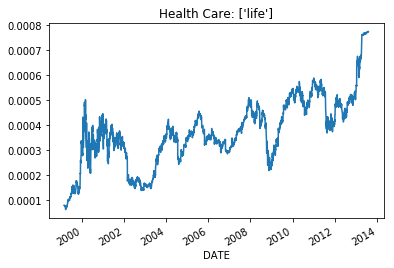

In [209]:
sd.plot_sector('Health Care', rel = True)

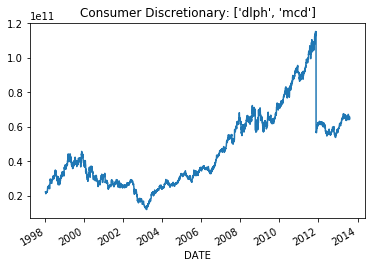

In [211]:
sd.plot_sector('Consumer Discretionary', rel = False)

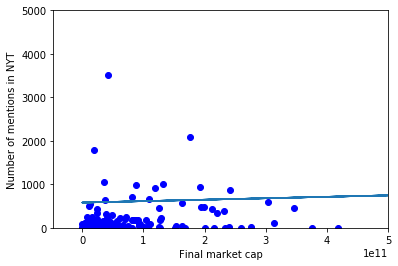

In [320]:
sd.plot_caps_vs_hits(ymin = 0, xmax = 0.5 * 1e12, ymax = 5000)

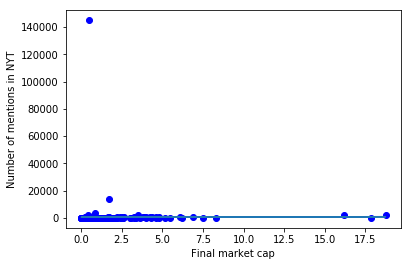

In [305]:
sd.plot_caps_vs_hits(rel = True)

In [50]:
sd.print_table(sortby = 2, sector = 'Consumer Discretionary')

Stock, market cap, relative market cap, growth ratio, hits
dlph: DELPHI TECHNOLOGIES PLC: 3990000000.0, 1.0, 2.624952164073684, 0
mcd: MCDONALDS CORP: 125430000000.0, 1.770693143852054, 5.639273761423344, 18
